<a href="https://colab.research.google.com/github/wangbcbill/Deep-Learning/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2019 Winter STAT 231B --- HW05 Part2 GAN

You are required to implement GAN using MNIST. 

Tamplate are provided. Do not modify the first code blocks. You only need to modify codes in second code block and parameters in third block. There are incomplete code inside TODO blocks, feel free to delete it. 

If error is due to "reuse ...." or "already defined...", restart the kernal.

* Remember to change to GPU while running. It's 20x faster!
* Since the output is too long, I failed to print full result to pdf. If you also face this problem, just upload ipynb files.
* You can use pytorch if you prefer doing that. Same requirement as this tamplate. Please at least output sampling image, reconstructed image and loss curve at the end. 
* You are allowed and welcomed to reference the online tutorial and code. HOWEVER, make sure you understand them and fill lines into this tamplates instead of copy-paste. There are limit number of code you can refer to ------ believe me, I already read all of them when I did my hw before. 

In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt


# Util function, no need to modify

def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), tf.shape(deconv))
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=25, margin=2):
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()


def inverse_transform(images):
    return (images+1.)/2.


In [0]:

class DCGAN(object):
    def __init__(self, sess, image_size=28, z_dim=5, batch_size=1100, GPU=True):
        """
        Args:
          sess: TensorFlow session
          input_size: The size of input image.
          batch_size: The size of batch. Should be specified before training.
          z_dim: (optional) Dimension of dim for Z. [100]
          c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [1]
        """
        self.sess = sess
        self.sample_num = 100
        self.print_step= 1

        self.input_size = image_size
        self.output_size = image_size
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.c_dim = 1

        self.GPU = GPU
        
        if self.GPU:
            device_name = '/gpu:0'
        else:
            device_name = '/cpu:0'
        
        with tf.device(device_name):
            self.build_model()

    def discriminator(self, image, reuse=False, train=True):
        with tf.variable_scope("discriminator", reuse=reuse):
            #######################################################
            # TODO: Define discriminator network structure here. op.py
            # includes some basic layer functions for you to use.
            # Please use batch normalization layer after conv layer.
            # And use 'train' argument to indicate the mode of bn.
            #######################################################

            l1 = lrelu(batch_norm(conv2d(image, 32, name="layer1"), train=train, name="bn1"))
            
            l2 = lrelu(batch_norm(conv2d(l1, 64, name="layer2"), train=train, name="bn2"))
            
            l3 = lrelu(batch_norm(conv2d(l2, 64, d_h=1, d_w=1, name="layer3"), train=train, name="bn3"))
            
            output = linear(tf.contrib.layers.flatten(l3), 1, scope="mean")
                              
            
            
            return tf.nn.sigmoid(output), output
        
            #######################################################
            #                   end of your code
            #######################################################

    def generator(self, z, reuse=False, train=True):
        with tf.variable_scope("generator", reuse=reuse):
            #######################################################
            # TODO: Define decoder network structure here. The size
            # of output should match the size of images. Image scale
            # in DCGAN is [-1, +1], so you need to add a tanh layer
            # before the output. Also use batch normalization layer
            # after deconv layer, and use 'train' argument to indicate
            # the mode of bn layer. Note that when sampling images
            # using trained model, you need to set train='False'.
            #######################################################

                        
            l5 = lrelu(batch_norm(tf.reshape(linear(z, 14*14*64, scope="layer5"), [-1, 14, 14, 64]),train=train, name="bn4"))
            
            l6 = lrelu(batch_norm(deconv2d(l5, [tf.shape(z)[0], 14, 14, 64], d_h=1, d_w=1, 
                                          name="layer6"), train=train, name="bn5"))
            
            l7 = lrelu(batch_norm(deconv2d(l6, [tf.shape(z)[0], 28, 28, 32], name="layer7"), train=train, name="bn6"))
            
            output = deconv2d(l7, [tf.shape(z)[0], 28, 28, 1], d_h=1, d_w=1, name="layer8")
            
            
            return tf.nn.tanh(output)
            
            #######################################################
            #                   end of your code
            #######################################################

    def build_model(self):
        #######################################################
        # TODO: In this build_model function, define inputs,
        # operations on inputs and loss of DCGAN. For input,
        # you need to define it as placeholders. Discriminator
        # loss has two parts: cross entropy for real images and
        # cross entropy for fake images generated by generator.
        # Set reuse=True for discriminator when calculating the
        # second cross entropy. Define two different loss terms
        # for discriminator and generator, and save them as
        # self.d_loss and self.g_loss respectively.
        #######################################################


        # variables : input
        self.x = tf.placeholder(tf.float32, shape=(None, self.input_size, self.input_size, self.c_dim))
        self.z = tf.placeholder(tf.float32, shape=(None, self.z_dim))
        self.isTrain = tf.placeholder(dtype=tf.bool)

        # networks :
        self.gen = self.generator(self.z, train=self.isTrain)
        self.d_real, self.d_real_score = self.discriminator(self.x, train=self.isTrain)
        self.d_fake, self.d_fake_score = self.discriminator(self.gen, train=self.isTrain, reuse=True)

        # loss for each network
        self.d_loss = - tf.reduce_mean(tf.log(self.d_real + 1e-12)) - tf.reduce_mean(tf.log(1. - self.d_fake + 1e-12))
        self.g_loss = - tf.reduce_mean(tf.log(self.d_fake + 1e-12))

        #######################################################
        #                   end of your code
        #######################################################
        # define var lists for generator and discriminator
        t_vars = tf.trainable_variables()

        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]


    def train(self, num_epoch=25, lr=0.0002, beta1=0.5):
        # create two optimizers for generator and discriminator,
        # and only update the corresponding variables.
        d_optim = tf.train.AdamOptimizer(lr, beta1=beta1) \
            .minimize(self.d_loss, var_list=self.d_vars)
        g_optim = tf.train.AdamOptimizer(lr, beta1=beta1) \
            .minimize(self.g_loss, var_list=self.g_vars)
        try:
            self.sess.run(tf.global_variables_initializer())
        except:
            tf.initialize_all_variables().run()
    
            
        # load MNIST data
        mnist = tf.keras.datasets.mnist
        (data, _), (_,_) = mnist.load_data()
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255 * 2.0 - 1.0
        data_len = data.shape[0]

        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        z_sample = np.random.uniform(-1, 1, size=[self.sample_num, self.z_dim])
        
        for epoch in range(num_epoch):
            batch_idxs = data_len // self.batch_size
            batch_d_loss = batch_g_loss = 0
            epoch_start_time = time.time()

            for idx in range(0, batch_idxs):
                batch_images = data[idx * self.batch_size:(idx + 1) * self.batch_size, :]
                #######################################################
                # TODO: Train your model here. Sample hidden z from
                # standard uniform distribution. In each step, run g_optim
                # twice to make sure that d_loss does not go to zero.
                # print the loss terms at each training step to monitor
                # the training process. Print sample images every
                # self.print_step steps.You may use function
                # save_images in utils.py to save images.
                #######################################################
                
                z_hidden = np.random.uniform(-1, 1, size=[self.batch_size, self.z_dim])
                
                _, d_loss = self.sess.run([d_optim, self.d_loss], feed_dict={self.x: batch_images, self.z: z_hidden, self.isTrain: True})
                
                self.sess.run(g_optim, feed_dict={self.z: z_hidden, self.isTrain: True})
                
                _, g_loss = self.sess.run([g_optim, self.g_loss], feed_dict={self.z: z_hidden, self.isTrain: True})
                
                batch_d_loss += d_loss
                batch_g_loss += g_loss
                
                
                #######################################################
                #                   end of your code
                #######################################################

            sample_image = self.sess.run(self.gen, {self.z: z_sample, self.isTrain: False})
            output_image = img2cell(inverse_transform(sample_image))
            plt.imshow(output_image)
            plt.axis('off')
            plt.show()
            epoch_end_time = time.time()
            batch_d_loss /= batch_idxs
            batch_g_loss /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('[%d/%d] - time: %.2f loss_d: %.3f, loss_g: %.3f'
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_d_loss, batch_g_loss))
            train_hist['D_losses'].append(batch_d_loss)
            train_hist['G_losses'].append(batch_g_loss)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
        plt.plot(train_hist['D_losses'])
        plt.plot(train_hist['G_losses'])
        plt.show()


Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


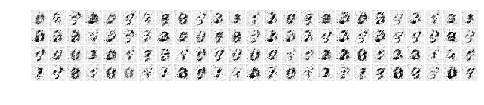

[1/25] - time: 45.51 loss_d: 2.408, loss_g: 0.464


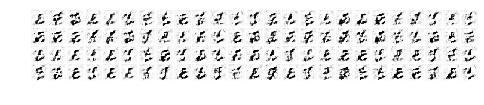

[2/25] - time: 41.74 loss_d: 1.516, loss_g: 0.735


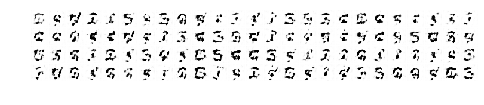

[3/25] - time: 41.86 loss_d: 1.453, loss_g: 0.818


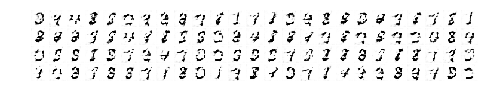

[4/25] - time: 41.82 loss_d: 1.397, loss_g: 0.832


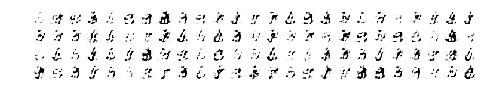

[5/25] - time: 41.79 loss_d: 1.392, loss_g: 0.841


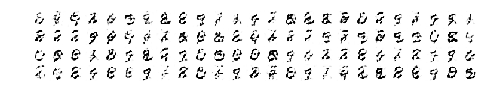

[6/25] - time: 41.83 loss_d: 1.365, loss_g: 0.835


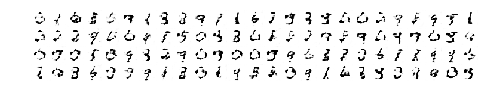

[7/25] - time: 41.77 loss_d: 1.335, loss_g: 0.827


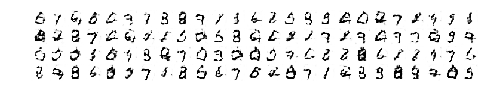

[8/25] - time: 41.82 loss_d: 1.374, loss_g: 0.788


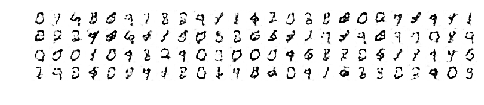

[9/25] - time: 41.75 loss_d: 1.363, loss_g: 0.782


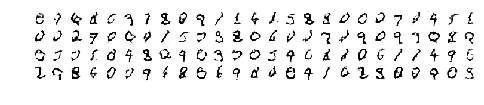

[10/25] - time: 41.78 loss_d: 1.362, loss_g: 0.763


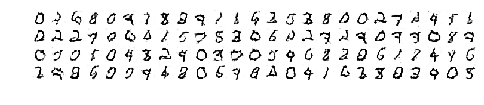

[11/25] - time: 41.81 loss_d: 1.375, loss_g: 0.755


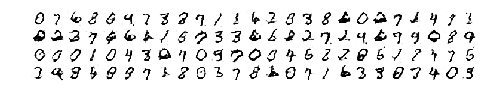

[12/25] - time: 41.78 loss_d: 1.376, loss_g: 0.757


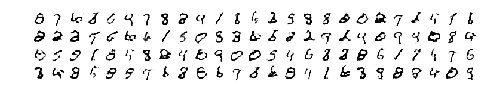

[13/25] - time: 41.77 loss_d: 1.362, loss_g: 0.759


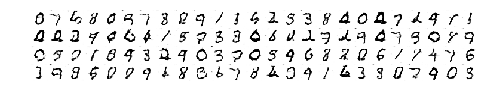

[14/25] - time: 41.76 loss_d: 1.369, loss_g: 0.759


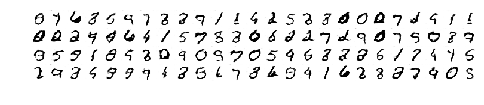

[15/25] - time: 41.81 loss_d: 1.352, loss_g: 0.759


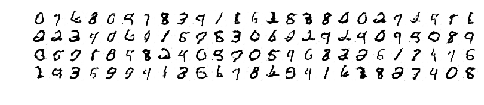

[16/25] - time: 41.78 loss_d: 1.361, loss_g: 0.760


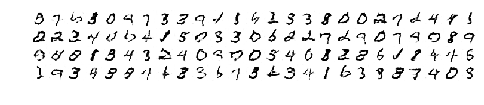

[17/25] - time: 41.70 loss_d: 1.363, loss_g: 0.760


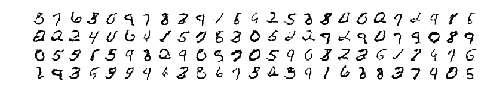

[18/25] - time: 41.77 loss_d: 1.367, loss_g: 0.772


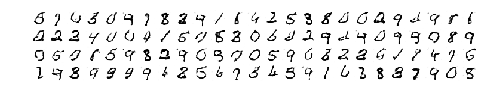

[19/25] - time: 41.69 loss_d: 1.362, loss_g: 0.765


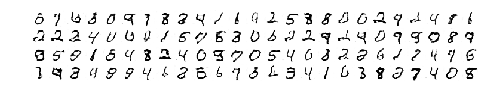

[20/25] - time: 41.73 loss_d: 1.358, loss_g: 0.758


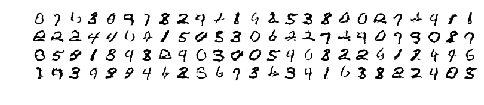

[21/25] - time: 41.75 loss_d: 1.363, loss_g: 0.753


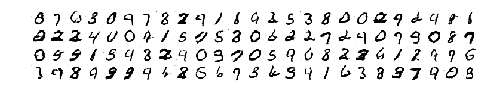

[22/25] - time: 41.72 loss_d: 1.366, loss_g: 0.761


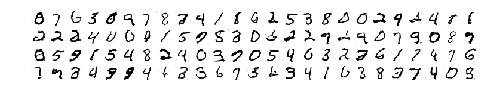

[23/25] - time: 41.78 loss_d: 1.361, loss_g: 0.744


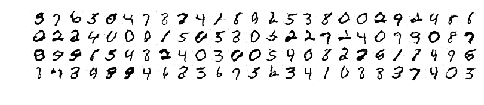

[24/25] - time: 41.67 loss_d: 1.369, loss_g: 0.741


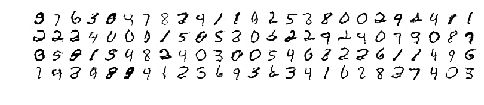

[25/25] - time: 41.71 loss_d: 1.368, loss_g: 0.743


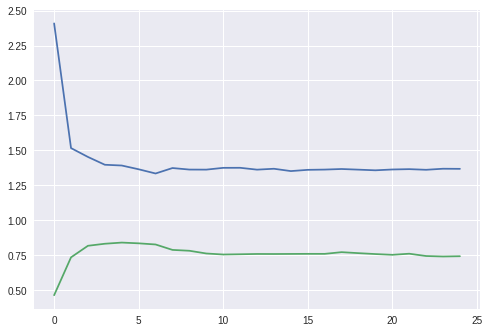

In [3]:
with tf.Session() as sess:
    dcgan = DCGAN(sess, batch_size=1100, image_size=28, z_dim=100, GPU=True)
    dcgan.train(num_epoch=25, lr=0.0002, beta1=0.5)